<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

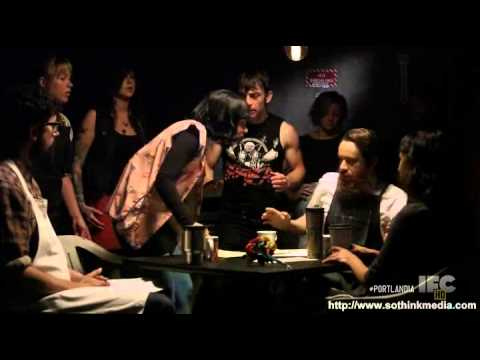

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\btros\\Repos\\Lambda\\DS-Unit-4-Sprint-1-NLP\\btr-assignments'

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)

## Sanitize

In [4]:
import numpy as np
import re

In [5]:
shops_copy = shops.copy()

### Feature Extraction 1

- clean up the dataset and extract non textual features 

In [6]:
# strip whitespace from ends of column entries
for column in shops.columns:
    shops[column] = shops[column].str.strip()
    
# make the rating column more useful by dropping redundant information
# and casting to int
shops['star_rating'] = shops['star_rating'].apply(lambda x: int(x[0]))

# may not be import for nlp or text processing but it is important information
shops['review_date'] = shops['full_review_text'].str.split().str[0]
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: x.replace(x.split()[0], '')) #drop redundancy

# more feature extraction - number of reviewers check-ins
shops['reviewer_checkins'] = shops['full_review_text'].str.extract(pat = r'(\d check-ins?)')
shops['full_review_text'] = shops['full_review_text'].str.replace(r'(\d check-ins?)', '')

# and again casting to int
shops['reviewer_checkins'] = shops['reviewer_checkins'].apply(lambda x: int(x[0]) if type(x) == str else int(0))

shops.head() 

,coffee_shop_name,full_review_text,star_rating,review_date,reviewer_checkins
0,The Factory - Cafe With a Soul,Love love loved the atmosphere! Every corner...,5,11/25/2016,1
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aus...",4,12/2/2016,0
2,The Factory - Cafe With a Soul,Listed in Brunch Spots I loved the eclectic ...,4,11/30/2016,1
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating Ho...,2,11/25/2016,0
4,The Factory - Cafe With a Soul,They are located within the Northcross mall ...,4,12/3/2016,1


### Text Processing

- extracting textual features using non nlp techniques

In [7]:
# word count
shops['word_count'] = shops['full_review_text'].apply(lambda x: len(x.split()))

# avg word length
shops['avg_word_len'] = shops['full_review_text'].apply(lambda x: pd
                                                        .Series(x.split()) #list to series
                                                        .str.len() # indvidual word length
                                                        .sum() / len(x.split())) # formula for mean

# all caps word count
shops['all_caps_freq'] = shops['full_review_text'].apply(lambda x: \
                                                         len([x for x \
                                                              in x.split() # list comprehension \ 
                                                              if (x.isupper()) # including only all uppercase words
                                                              & (len(x) > 2)])) # longer than 2 chars


# number of sentences ending with !
shops['exclamatories_count'] = shops['full_review_text'].apply(lambda x:\
                                                                len(re.findall(r'[\s\b\w]*[!]{1,10}', x)))

# number of sentences ending with ?
shops['interrogatives_count'] = shops['full_review_text'].apply(lambda x:\
                                                                len(re.findall(r'[\s\b\w]*[?]{1,10}', x)))

shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,reviewer_checkins,word_count,avg_word_len,all_caps_freq,exclamatories_count,interrogatives_count
0,The Factory - Cafe With a Soul,Love love loved the atmosphere! Every corner...,5,11/25/2016,1,95,4.652632,0,4,1
1,The Factory - Cafe With a Soul,"Listed in Date Night: Austin, Ambiance in Aus...",4,12/2/2016,0,47,5.297872,1,3,0
2,The Factory - Cafe With a Soul,Listed in Brunch Spots I loved the eclectic ...,4,11/30/2016,1,238,4.260504,0,1,1
3,The Factory - Cafe With a Soul,Very cool decor! Good drinks Nice seating Ho...,2,11/25/2016,0,67,4.477612,0,1,0
4,The Factory - Cafe With a Soul,They are located within the Northcross mall ...,4,12/3/2016,1,114,4.482456,0,0,0


### Preprocess
- cleaning the text data and removal of stop words(global), and common and rare words from our data.

In [8]:
# remove punctuation
shops['full_review_text'] = shops['full_review_text'].str.replace('[^\w\s]','')

#and force to lower
shops['full_review_text'] = shops['full_review_text'].str.lower()

# word frequency
freq = pd.Series(' '.join(shops['full_review_text']).split()).value_counts()

freq[:5]

the    34807
and    26650
a      22755
i      20237
to     17160
dtype: int64

In [10]:
def pct_change(word_freq):
    """
    stops when the pct change between descending word frequency removal is less than 1%
    """
    change = 1.1
    total = sum(word_freq.values)
    step = 1
    while change > .01:
        curr = word_freq[step]
        prior = total - sum(word_freq.values[:step])
        change = curr / prior
        
        print(word_freq[:step].index[-1], end="  ")
        print(f'{change:.5f}', step, end="  |||")
        if step % 4 == 0:
            print('\n')
        step +=1
    curr = word_freq[step]
    prior = total - sum(word_freq.values[:step])
    change = curr / prior
    print(word_freq[:step].index[-1], end="  ")
    print(f'{change:.5f}', end="  |||")

In [11]:
pct_change(freq)

the  0.03634 1  |||and  0.03220 2  |||a  0.02959 3  |||i  0.02585 4  |||

to  0.01949 5  |||of  0.01893 6  |||is  0.01665 7  |||coffee  0.01587 8  |||

was  0.01586 9  |||in  0.01583 10  |||it  0.01489 11  |||for  0.01146 12  |||

this  0.01145 13  |||but  0.01128 14  |||with  0.01118 15  |||my  0.01124 16  |||

they  0.01134 17  |||that  0.01090 18  |||you  0.01023 19  |||place  0.01000 20  |||

on  0.00965  |||

In [12]:
common = list(freq[:20].index)
rare = list((freq.loc[freq.values < 3]).index)

# remove common and rare words 

shops['full_review_text'] = shops['full_review_text'].apply(lambda x:
                                " ".join([x for x in x.split() if x not in common]))

shops['full_review_text'] = shops['full_review_text'].apply(lambda x: 
                                 " ".join([x for x in x.split() if x not in common]))

In [13]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,reviewer_checkins,word_count,avg_word_len,all_caps_freq,exclamatories_count,interrogatives_count
0,The Factory - Cafe With a Soul,love love loved atmosphere every corner shop h...,5,11/25/2016,1,95,4.652632,0,4,1
1,The Factory - Cafe With a Soul,listed date night austin ambiance austin beaut...,4,12/2/2016,0,47,5.297872,1,3,0
2,The Factory - Cafe With a Soul,listed brunch spots loved eclectic homey plush...,4,11/30/2016,1,238,4.260504,0,1,1
3,The Factory - Cafe With a Soul,very cool decor good drinks nice seating howev...,2,11/25/2016,0,67,4.477612,0,1,0
4,The Factory - Cafe With a Soul,are located within northcross mall shopping ce...,4,12/3/2016,1,114,4.482456,0,0,0


### spacy

In [14]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [95]:
# Tokenizer Pipe
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)

shops['description'] = tokens
shops.head()

NameError: name 'jobs' is not defined

In [ ]:
# Wrap it all in a function
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: # punctuation already removed
        if (token.is_stop==False) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas


In [96]:
jobs['lemmas'] = jobs['description'].apply(get_lemmas)
jobs

NameError: name 'jobs' is not defined

In [43]:
# seperate postive and negative reviews now that the features have been extracted 
# and text processed
bad_reviews = shops.loc[shops['star_rating']  < 4]
good_reviews = shops.loc[shops['star_rating']  >= 4]
assert len(shops) == len(bad_reviews) + len(good_reviews)
len(bad_reviews), len(good_reviews)

(1476, 6140)

In [44]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,reviewer_checkins,word_count,avg_word_len,all_caps_freq,exclamatories_count,interrogatives_count,review_tokens,lemmas
0,The Factory - Cafe With a Soul,love love loved atmosphere every corner shop h...,5,11/25/2016,1,95,4.652632,0,4,1,"[love, love, loved, atmosphere, corner, shop, ...","[love, love, love, atmosphere, corner, shop, s..."
1,The Factory - Cafe With a Soul,listed date night austin ambiance austin beaut...,4,12/2/2016,0,47,5.297872,1,3,0,"[listed, date, night, austin, ambiance, austin...","[list, date, night, austin, ambiance, austin, ..."
2,The Factory - Cafe With a Soul,listed brunch spots loved eclectic homey plush...,4,11/30/2016,1,238,4.260504,0,1,1,"[listed, brunch, spots, loved, eclectic, homey...","[list, brunch, spot, love, eclectic, homey, pl..."
3,The Factory - Cafe With a Soul,very cool decor good drinks nice seating howev...,2,11/25/2016,0,67,4.477612,0,1,0,"[cool, decor, good, drinks, nice, seating, ove...","[cool, decor, good, drink, nice, seating, over..."
4,The Factory - Cafe With a Soul,are located within northcross mall shopping ce...,4,12/3/2016,1,114,4.482456,0,0,0,"[located, northcross, mall, shopping, center, ...","[locate, northcross, mall, shopping, center, f..."


### Copypasta

In [45]:
from collections import Counter
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [56]:
wc = count(shops['lemmas']).reset_index(drop=True)
bad_wc = count(bad_reviews['lemmas']).reset_index(drop=True)
good_wc = count(good_reviews['lemmas']).reset_index(drop=True)

In [62]:
for i in range(0,20):
    print(bad_wc.iloc[i].word,"    ",wc.iloc[i].word,"     ",good_wc.iloc[i].word)

not      good       good
good      not       great
like      great       not
order      like       like
come      come       love
time      time       austin
drink      love       come
food      drink       shop
have      austin       time
great      shop       drink
get      order       try
service      try       have
be      have       latte
go      get       friendly
shop      food       get
try      be       work
work      work       nice
people      latte       be
taste      nice       food
pretty      friendly       order


In [63]:
good_words = list(good_wc['word'].values)
bad_words = list(bad_wc['word'].values)

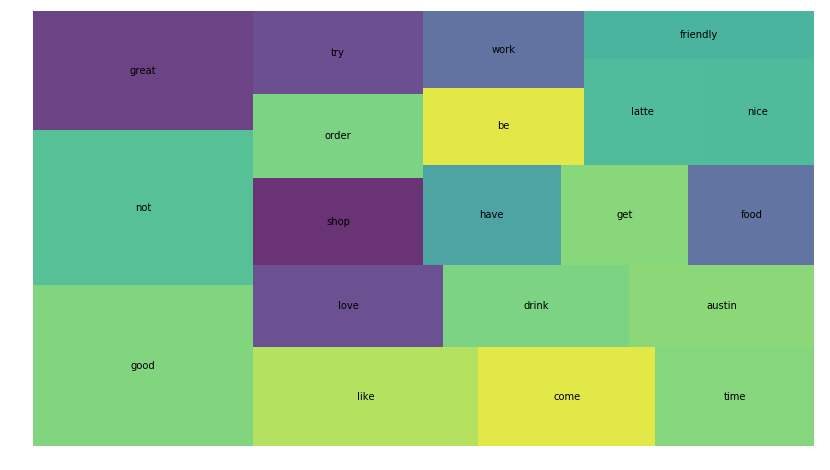

In [64]:
import squarify
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.ion()

cut = 20


wc_top20 = wc[wc['rank'] <= cut]
fig, axes = plt.subplots(figsize=(14, 8))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

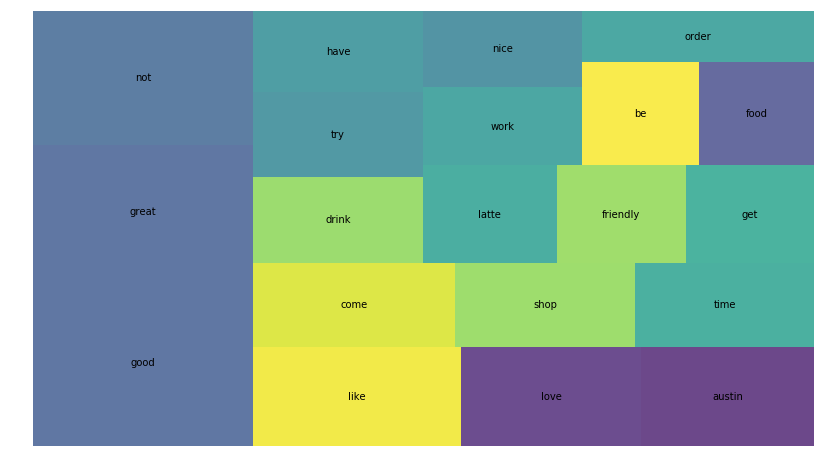

In [69]:
good_top20 = good_wc[good_wc['rank'] <= cut]
fig, axes = plt.subplots(figsize=(14, 8))
squarify.plot(sizes=good_top20['pct_total'], label=good_top20['word'], alpha=.8 )
plt.axis('off')
plt.show();

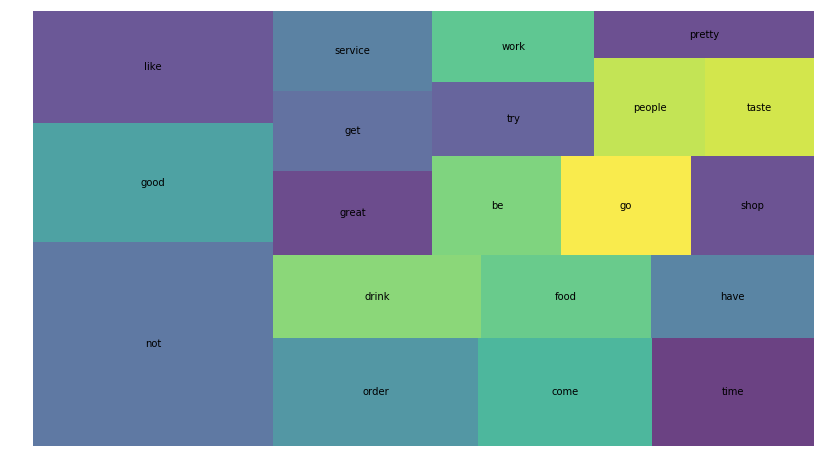

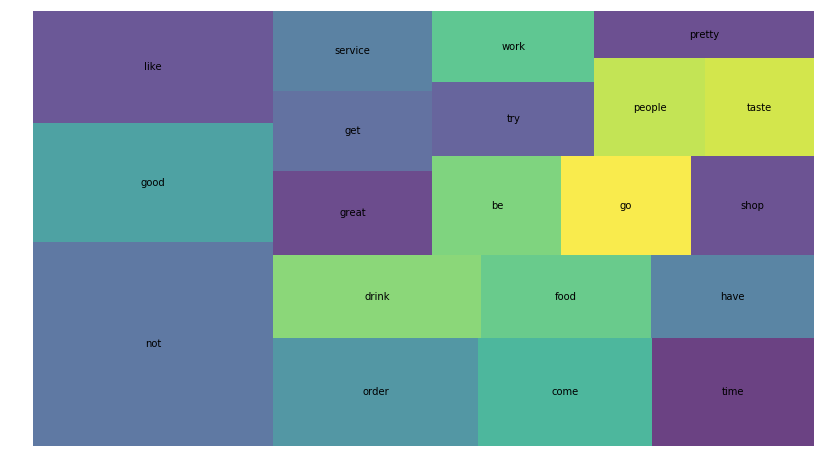

In [68]:
bad_top20 = bad_wc[bad_wc['rank'] <= cut]
fig, axes = plt.subplots(figsize=(14, 8))
squarify.plot(sizes=bad_top20['pct_total'], label=bad_top20['word'], alpha=.8 )
plt.axis('off')
display(fig)

### Some differences already
- good reviews are more similar to the overall than bad, but there is more good reviews
- some strong negative sentiment in the bad reviews 

### Let's check unique words

In [85]:
bad_unique = bad_wc.merge(good_wc, on='word', how='left', indicator=True) # left merge w/ indicator
# filter df for left_only
bad_unique = bad_unique[bad_unique["_merge"] == "left_only"].drop(columns=["_merge"]).reset_index(drop=True)
# drop the leftover columns
drops = list(bad_unique.columns[-6:])
bad_unique = bad_unique.drop(columns=drops)
# fix the headers still standing
fix = bad_unique.columns.str.replace("_x", "")
bad_unique.columns = fix
bad_unique.head(5)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
0,rudely,7,7,1409.0,0.000091,0.846909,0.004743
1,rudeness,7,7,1501.0,0.000091,0.855277,0.004743
2,letdown,6,6,1590.0,0.000078,0.862593,0.004065
3,overcharge,4,6,1591.0,0.000078,0.862671,0.002710
4,1word,3,6,1605.0,0.000078,0.863762,0.002033


In [86]:
good_unique = good_wc.merge(bad_wc, on='word', how='left', indicator=True) # left merge w/ indicator
# filter df for left_only
good_unique = good_unique[good_unique["_merge"] == "left_only"].drop(columns=["_merge"]).reset_index(drop=True)
# drop the leftover columns
drops = list(good_unique.columns[-6:])
good_unique = good_unique.drop(columns=drops)
# fix the headers still standing
fix = good_unique.columns.str.replace("_x", "")
good_unique.columns = fix
good_unique.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
0,passion,42,52,864.0,0.000193,0.768985,0.006840
1,venezia,44,52,866.0,0.000193,0.769371,0.007166
2,knowledgable,45,46,933.0,0.000171,0.781538,0.007329
3,st,40,46,937.0,0.000171,0.782221,0.006515
4,fleet,26,43,982.0,0.000160,0.789654,0.004235


In [81]:
bad_unique.columns.str.replace("_x", "")

Index(['word', 'appears_in', 'count', 'rank', 'pct_total', 'cul_pct_total',
       'appears_in_pct'],
      dtype='object')

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

(0.0, 100.0, 0.0, 100.0)

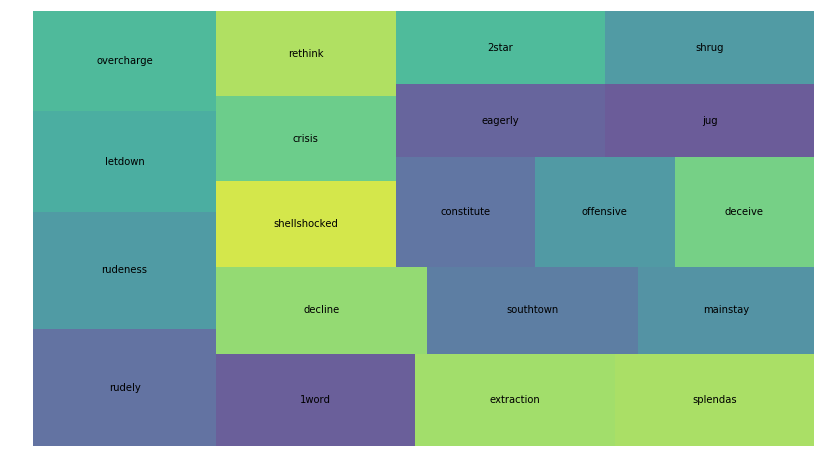

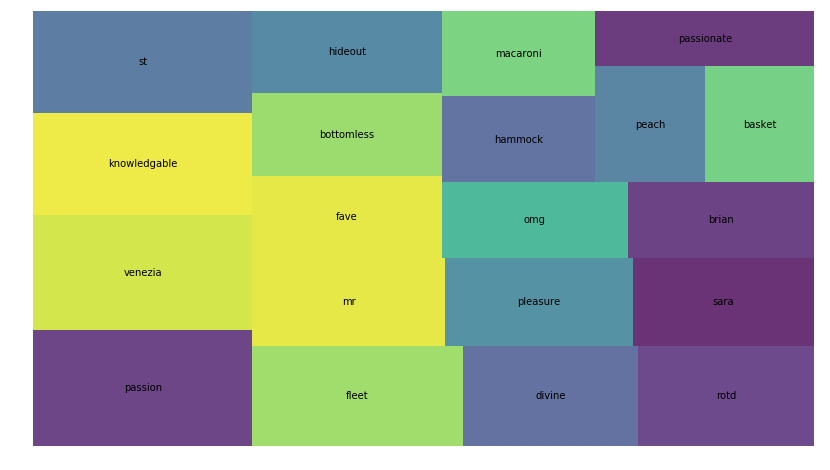

In [89]:
top20 = bad_unique.head(20)
fig, axes = plt.subplots(figsize=(14, 8))
squarify.plot(sizes=top20['pct_total'], label=top20['word'], alpha=.8 )
plt.axis('off')
# display(fig)

top20 = good_unique.head(20)
fig, axes = plt.subplots(figsize=(14, 8))
squarify.plot(sizes=top20['pct_total'], label=top20['word'], alpha=.8 )
plt.axis('off')
# display(fig)

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [92]:
diff = good_wc.merge(bad_wc, on='word', suffixes=('_good','_bad'))
diff['differences'] = abs(diff['pct_total_good'] - diff['pct_total_bad'])
diff = diff.sort_values(by=['differences'], ascending=False).reset_index(drop=True)
diff.head(20)

,word,appears_in_good,count_good,rank_good,pct_total_good,cul_pct_total_good,appears_in_pct_good,appears_in_bad,count_bad,rank_bad,pct_total_bad,cul_pct_total_bad,appears_in_pct_bad,differences
0,not,2187,3469,3.0,0.012891,0.041892,0.356189,868,1706,1.0,0.022167,0.022167,0.588076,0.009276
1,great,2505,3474,2.0,0.012910,0.029000,0.407980,348,472,10.0,0.006133,0.100350,0.235772,0.006777
2,order,1023,1383,20.0,0.005139,0.148522,0.166612,437,773,4.0,0.010044,0.057393,0.296070,0.004905
3,love,1593,2101,5.0,0.007808,0.058685,0.259446,211,255,37.0,0.003313,0.219774,0.142954,0.004494
4,austin,1570,2012,6.0,0.007477,0.066162,0.255700,244,288,30.0,0.003742,0.195645,0.165312,0.003735
5,delicious,1177,1312,21.0,0.004876,0.153397,0.191694,83,88,161.0,0.001143,0.455750,0.056233,0.003732
6,like,1671,2418,4.0,0.008986,0.050877,0.272150,594,940,3.0,0.012214,0.047349,0.402439,0.003228
7,good,2922,4330,1.0,0.016091,0.016091,0.475896,648,998,2.0,0.012968,0.035135,0.439024,0.003123
8,ask,311,346,139.0,0.001286,0.429303,0.050651,220,325,25.0,0.004223,0.176362,0.149051,0.002937
9,friendly,1417,1483,14.0,0.005511,0.116589,0.230782,181,201,55.0,0.002612,0.272632,0.122629,0.002899


(0.0, 100.0, 0.0, 100.0)

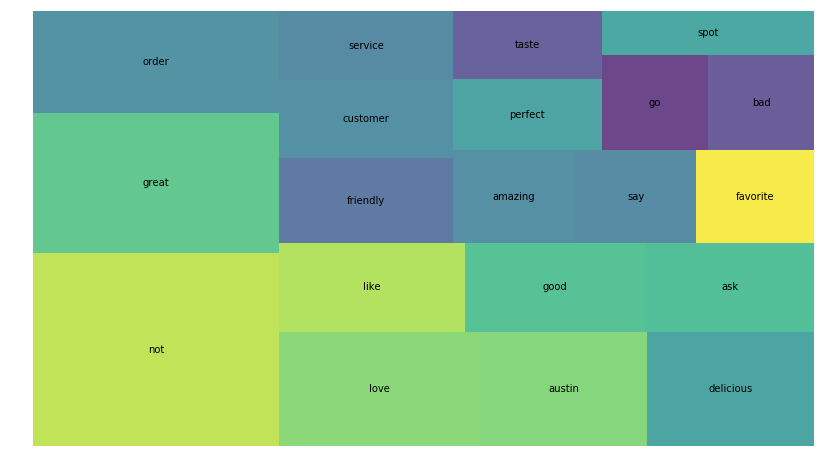

In [94]:
top20 = diff.head(20)
fig, axes = plt.subplots(figsize=(14, 8))
squarify.plot(sizes=top20['differences'], label=top20['word'], , alpha=.8 )
plt.axis('off')

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

